In [1]:
# This cells setups the environment when executed in Google Colab.
try:
    import google.colab
    !curl -s https://raw.githubusercontent.com/ibs-lab/cedalion/dev/scripts/colab_setup.py -o colab_setup.py
    # Select branch with --branch "branch name" (default is "dev")
    %run colab_setup.py
except ImportError:
    pass

In [2]:
import cedalion
import cedalion.datasets
from cedalion import units
import cedalion.sigproc.quality as quality
from cedalion.sigproc.frequency import sampling_rate
from cedalion.sigdecomp import ERBM 
import numpy as np
import xarray as xr
import scipy as sp 
import matplotlib.pyplot as plt


# Example for ICA Source Extraction 

[Independent Component Analysis](https://en.wikipedia.org/wiki/Independent_component_analysis) (ICA) is a method for separating multivariate signals into statistically independent non-Gaussian components.
In this notebook we will investigate an example on how [Independent Component Analysis by Entropy Rate Bound Minimization](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6845364) (ICA-ERBM) can be used to extract physiological sources from fNIRS data. For this example, we will use a finger tapping dataset.  
Let $X \in \mathbb{R}^{N \times T }$ denote the finger tapping data with $N$ channels and $T$ time points. We assume that the data $X$ consists of unknown independent sources $S \in  \mathbb{R}^{N \times T }$ that were mixed through an unknown mixing matrix $A \in  \mathbb{R}^{N \times N}$, such that  
$$ X = A \cdot S. $$  
Source reconstruction in ICA-ERBM is done by minimizing the [entropy rate](https://en.wikipedia.org/wiki/Entropy_rate) of the estimated sources. A demixing matrix $W$ is determined and the estimated sources $\hat S \in  \mathbb{R}^{N \times T }$ can be computed as  
$$ \hat S = W \cdot X. $$
Among the extracted sources, we will identify the ones that correspond to the PPG and Mayer Wave signals. 


## Loading Raw Finger Tapping Data

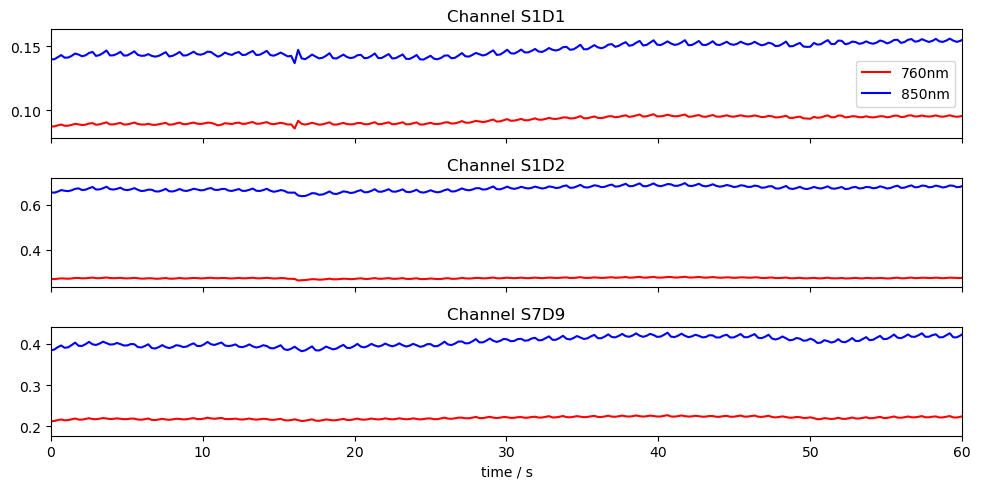

In [3]:
# Load finger tapping data set 
finger_tapping_data = cedalion.datasets.get_fingertappingDOT()

# Extract the fnirs recording 
fnirs_data = finger_tapping_data['amp']

# Plot three channels of the fnirs data
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i, ch in enumerate(["S1D1", "S1D2", "S7D9"]):
    ax[i].plot(fnirs_data.time, fnirs_data.sel(channel=ch, wavelength="760"), "r-", label="760nm")
    ax[i].plot(fnirs_data.time, fnirs_data.sel(channel=ch, wavelength="850"), "b-", label="850nm")
    ax[i].set_title(f"Channel {ch}")

ax[0].legend()
ax[2].set_xlim(0,60)
ax[2].set_xlabel("time / s")
plt.tight_layout()

## Conversion to Optical Density

In [4]:
# Convert to Optical Density (OD)
fnirs_data_od = cedalion.nirs.int2od(fnirs_data)

## Channel Quality Assessment and Pruning
The Scalp Coupling Index (SCI) and Peak Spectral Power (PSP) are used for quality assessment. We compute SCI and PSP for each channel, and remove channels with less than 75% of clean time. 

In [5]:
# Calculate masks for SCI and PSP quality metrics
window_length = 5 * units.s
sci_thresh = 0.75
psp_thresh = 0.1
sci_psp_percentage_thresh = 0.75

sci, sci_mask = quality.sci(fnirs_data_od, window_length, sci_thresh)
psp, psp_mask = quality.psp(fnirs_data_od, window_length, psp_thresh)
sci_x_psp_mask = sci_mask & psp_mask
perc_time_clean = sci_x_psp_mask.sum(dim="time") / len(sci.time)
sci_psp_mask = [perc_time_clean >= sci_psp_percentage_thresh]

# Prune channels that do not pass the quality test
fnirs_data_pruned, drop_list = quality.prune_ch(fnirs_data_od, sci_psp_mask, "all")

# Display pruned channels
print(f"List of pruned channels: {drop_list}  ({len(drop_list)})")


List of pruned channels: ['S13D26']  (1)


## High-pass filter

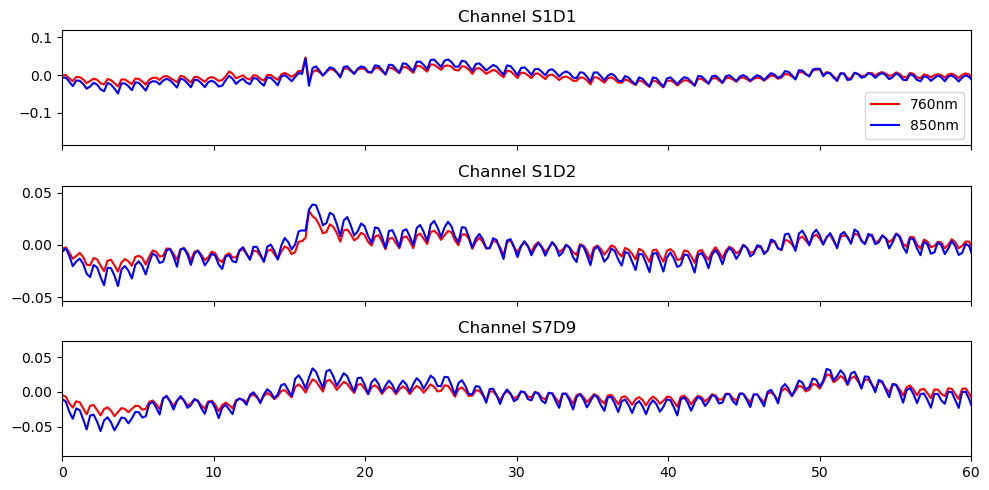

In [6]:
# Filter the data 
# fmax = 0 is used to indicate high-pass filtering
fnirs_data_filtered = fnirs_data_pruned.cd.freq_filter(fmin= 0.01, fmax= 0, butter_order=4)

# Store sampling rate
fnirs_data_samplingrate = sampling_rate(fnirs_data_pruned.time).magnitude

# Plot the filtered data
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i, ch in enumerate(["S1D1", "S1D2", "S7D9"]):
    ax[i].plot(fnirs_data_filtered.time, fnirs_data_filtered.sel(channel=ch, wavelength="760"), "r-", label="760nm")
    ax[i].plot(fnirs_data_filtered.time, fnirs_data_filtered.sel(channel=ch, wavelength="850"), "b-", label="850nm")
    ax[i].set_title(f"Channel {ch}")

ax[0].legend()
ax[2].set_xlim(0,60)
ax[2].set_label("time / s")
plt.tight_layout()

## Select Channels and Time Slice for ICA 

The entire finger tapping dataset was recorded over 30 minutes and contains 99 channels after pruning. Unfortunately, these dimensions result in a long runtime for ICA-ERBM. For this reason, we will use only a subset of the channels and a 10-minute slice of the selected channels. Despite the longer runtime, this example is also applicable to the full dataset.


In [7]:
# Choose the best 30 channels based on the percentage of time clean
id_best_channels = np.argsort(perc_time_clean).values[-30:]
best_channels = fnirs_data['channel'][id_best_channels]

# Extract the best channels from the filtered data
fnirs_best_channels = fnirs_data_filtered.sel(channel = best_channels)

# Select a 10 min interval
duration = 10 * 60  
buffer = 60 
fnirs_best_channels = fnirs_best_channels.sel(time=slice(buffer, buffer + duration))

# Select the first wavelength
X = fnirs_best_channels.values[:, 0, :] 
print(f"Shape of data for ICA-ERBM: {X.shape}")

Shape of data for ICA-ERBM: (30, 2616)


/opt/miniconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


## Apply ICA-ERBM  

ICA-ERBM is applied to the selected channels. For the autoregressive filter used in ICA-ERBM, we use the default parameter $p = 11$. The source estimates are then computed as $\hat S = W \cdot X$. 

In [8]:
# Set filter length 
p = 11 

# Apply ICA-ERBM to the data 
W = ERBM.ERBM(X, p)

# Compute separated source as S = W * X
sources = W.dot(X)

In [9]:
# Apply z-score normalization to the sources
sources_zscore = sp.stats.zscore(sources, axis=0)

## Selection of PPG Source

From the reconstructed sources, we now want to identify those that are most similar to a PPG signal. To this end, we compare the frequency band in which the PPG signal is expected to have large amplitudes with the surrounding frequency bands. The sources with the highest contrast are selected. The PPG signal is expected to exhibit high amplitudes in a frequency band around 1 Hz.

In [10]:
# Compute the frequency spectrum for each source
psd_sources = np.abs(np.fft.fft(sources, axis = 1))

# The frequencies corresponding to the spectrum 
freqs = np.fft.fftfreq(sources.shape[1], 1/fnirs_data_samplingrate)

# Choose the indices of frequencies that are in the ppg band (0.75 - 1.25 Hz)
ppg_band_ind = np.logical_and(freqs >= 0.75, freqs <= 1.25) 

# Choose the indices of frequencies that are in the band (0 - 0.75 Hz and 1.25 - 3.0 Hz)
comp_band =  np.logical_and(freqs >= 0, freqs < 0.75) +  np.logical_and(freqs > 1.25 , freqs <= 3.0) 

# Compute the quotient of the ppg band and the contrast band
psd_quotient = np.sum(psd_sources[:, ppg_band_ind], axis = 1 ) / np.sum(psd_sources[:, comp_band], axis = 1 )

# Choose the indices of the sources with the highest contrast 
max_contrast_index = np.argsort(psd_quotient, axis = 0 )[-5:]

# Reverse the order of the indices to have the highest contrast first
max_contrast_index = max_contrast_index[::-1]   

# Choose the sources with the highest contrast
ppg_sources = sources_zscore[max_contrast_index, :]

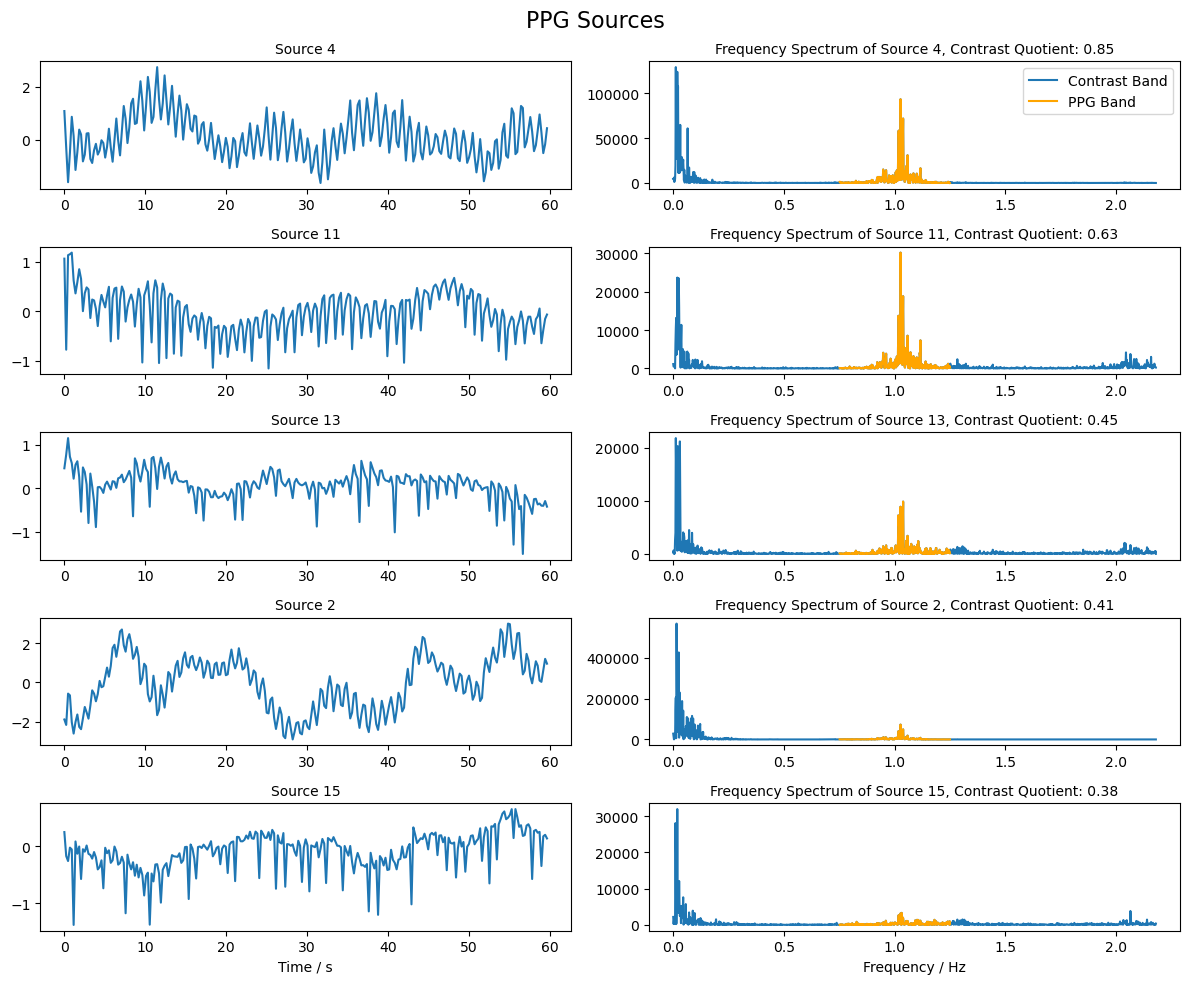

In [11]:
# Plot the sources with the highest contrast and their frequency spectrum
fig, ax = plt.subplots(ppg_sources.shape[0], 2, figsize=(12, 2 * ppg_sources.shape[0]))

for i in range(ppg_sources.shape[0]):

    # Plot the source for 60 seconds 
    l = int(fnirs_data_samplingrate * 60 * 1)
    ax[i, 0].plot( 1/fnirs_data_samplingrate * np.arange(0,l), ppg_sources[i, : l], label=f"Source {max_contrast_index[i]+1}")
    ax[i, 0].set_title(f"Source {max_contrast_index[i]+1}", fontsize=10)

    # Plot frequency spectrum of the source
    psd = np.abs(np.fft.rfft(ppg_sources[i, :]))**2
    x_freqs = np.fft.rfftfreq(ppg_sources.shape[1], 1/fnirs_data_samplingrate)
    ax[i, 1].plot(x_freqs, psd, label= 'Contrast Band')
    ax[i, 1].set_title(f"Frequency Spectrum of Source {max_contrast_index[i]+1}, Contrast Quotient: {psd_quotient[max_contrast_index[i]]:.2f}",  fontsize=10)

    # Highlight the PPG band in the frequency spectrum
    highlight_ppg_band = np.logical_and(x_freqs >= 0.75, x_freqs <= 1.25) 
    ax[i, 1].plot(x_freqs[highlight_ppg_band], psd[highlight_ppg_band], color='orange', label='PPG Band')

ax[0, 1].legend()
ax[i, 0].set_xlabel("Time / s")
ax[i, 1].set_xlabel("Frequency / Hz")
fig.suptitle("PPG Sources", fontsize=16)
plt.tight_layout()    


## Selection of Mayer Wave Source

Mayer waves are expected to have a frequency around 0.1 Hz. Similar to the PPG sources above, we will use the contrast between the frequency band around 0.1 Hz and the surrounding bands to rank the sources and identify those that are most similar to the Mayer wave.

In [12]:
# Choose the indices of frequencies that are in the Mayer Wave band (0.05 - 0.15 Hz)
mw_band_ind = np.logical_and(freqs >= 0.05, freqs <= 0.15) 

# Choose the indices of frequencies that are in the band (0 - 0.05 Hz and 0.15 - 3.0 Hz)
comp_band =  np.logical_and(freqs >= 0, freqs < 0.05) +  np.logical_and(freqs > 0.15 , freqs <= 3.0) 

# Compute the quotient of the Mayer Wave band and the contrast band
psd_quotient = np.sum(psd_sources[:, mw_band_ind], axis = 1 ) / np.sum(psd_sources[:, comp_band], axis = 1 )

# Choose the indices of the sources with the highest contrast 
max_contrast_index = np.argsort(psd_quotient, axis = 0 )[-5:]

# Reverse the order of the indices to have the highest contrast first
max_contrast_index = max_contrast_index[::-1]   

# Extract the sources with the highest contrast
mw_sources = sources_zscore[max_contrast_index, :]

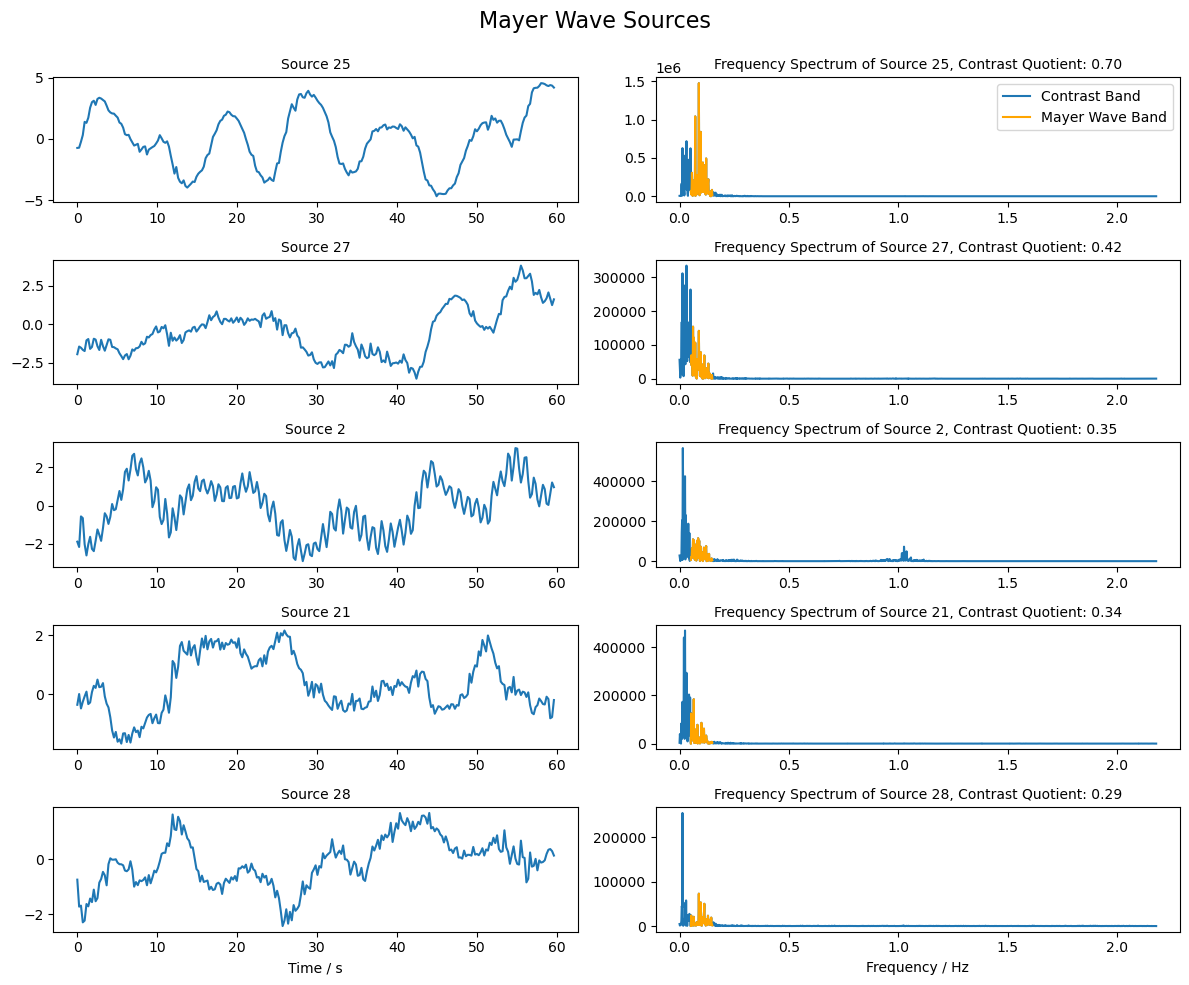

In [13]:
# Plot the sources with the highest contrast and their frequency spectrum
fig, ax = plt.subplots(mw_sources.shape[0], 2, figsize=(12, 2 * mw_sources.shape[0]))

for i in range(mw_sources.shape[0]):
    
    # Plot the source for 60 seconds 
    l = int(fnirs_data_samplingrate * 60 * 1)
    ax[i, 0].plot( 1/fnirs_data_samplingrate * np.arange(0,l), mw_sources[i, : l], label=f"Source {max_contrast_index[i]+1}")
    ax[i, 0].set_title(f"Source {max_contrast_index[i]+1}", fontsize=10)

    # Plot frequency spectrum of the source
    psd = np.abs(np.fft.rfft(mw_sources[i, :]))**2
    x_freqs = np.fft.rfftfreq(mw_sources.shape[1], 1/fnirs_data_samplingrate)
    ax[i, 1].plot(x_freqs, psd, label= 'Contrast Band')
    ax[i, 1].set_title(f"Frequency Spectrum of Source {max_contrast_index[i]+1}, Contrast Quotient: {psd_quotient[max_contrast_index[i]]:.2f}",  fontsize=10)

    # Highlight the Mayer Wave band in the frequency spectrum
    highlight_mw_band = np.logical_and(x_freqs >= 0.05, x_freqs <= 0.15) 
    ax[i, 1].plot(x_freqs[highlight_mw_band], psd[highlight_mw_band], color='orange', label='Mayer Wave Band')

ax[0, 1].legend()
ax[i, 0].set_xlabel("Time / s")
ax[i, 1].set_xlabel("Frequency / Hz")
fig.suptitle("Mayer Wave Sources", fontsize=16)
plt.tight_layout()    